# Overview

This jupyter notebook aims to summarize the total update of CO processes made in 2025 by Aurélien PILUSO (PhD student) in the Meudon PDR Code. 

An additional pdf document with all notes and references are also available along this notebook with the different data needed to run this doc. 

As for changes, we : 
- Used the HITRAN database from 2025 wih Gordon 2022 data to update the Aij, dE(K) and frequencies of radiative transitions
- Used the Stancil file (compared with BaseCol and Ema database and matching data) to update collision rates for CO with H and CO with o/p H2

In this notebook, we will go through the implementation of the update and the check at every step of the validity of the update. 

## 1. Preparation and data loading 


In [2]:
# Libraries importations : 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd    
import re 

pd.set_option("mode.chained_assignment", None)

import plotly.io as pio
pio.renderers.default = "notebook"

import sys
chemin_modules = "/Users/aurelien/Desktop/PhD/Codes/Package/Perso/"
sys.path.append(chemin_modules)

import to_PDR
import viz 
import modify as mod 
import read
import calculate 
#Constant definition in cgs for any conversion
clum= 2.99792458e10
h = 6.62607015e-27
k = 1.380649e-16
cm_k=h*clum/k
cm_GHz=29.9792458
m_GHZ=0.3


def extract_values(text):
    """Crée des colones en plus qui séparent les colonnes Quant nulles"""
    match = re.match(r"ElecStateLabel=X v=(\d+) J=(\d+)", text)
    if match:
        v = int(match.group(1))
        j = int(match.group(2))
        return v, j
    else:
        return None, None


def Nettoyage (x):
    return(int(x.split(';')[0]))



def renommer_inversement(df: pd.DataFrame) -> pd.DataFrame:
    mappage = {
        'NUM': 'ID',
        'UP': 'nu',
        'LOW': 'nl',
    }
    
    colonnes_a_renommer_pdr = [col for col in df.columns if col.endswith('_PDR')]
    for col in colonnes_a_renommer_pdr:
        mappage[col] = col.replace('K_PDR', 'Ke')
    
    return df.rename(columns=mappage)

In [4]:


#Reading of Meudon PDR files for levels, lines and collisions provided with the notebook. The data given are the old data from the Meudon PDR Code 
path="/Users/aurelien/Desktop/PhD/Data/"

###############################Meudon PDR Files
#Level file
df_level_co = to_PDR.Level_to_pd("co")         

#Line file
df_co = to_PDR.Lines_to_pd2("co")
df_co['Frequency_GHz'] = df_co['Description_text'].str.extract('(\d+\.?\d*)\s*GHz')[0].astype(float)

#Collision files
df_co_oh2_Meudon = to_PDR.read_collision_to_df("co_oh2")   
df_Meudon_oH2 = to_PDR.merge_level_data(df_co_oh2_Meudon, df_level_co,Col_transi=["UP","LOW"], Level_transi=["n","v","J"])  
df_Meudon_oH2 = renommer_inversement(df_Meudon_oH2)

df_co_ph2_Meudon = to_PDR.read_collision_to_df("co_ph2")   
df_Meudon_pH2 = to_PDR.merge_level_data(df_co_ph2_Meudon, df_level_co,Col_transi=["UP","LOW"], Level_transi=["n","v","J"])  
df_Meudon_pH2 = renommer_inversement(df_Meudon_pH2)

df_co_h_Meudon = to_PDR.read_collision_to_df("co_h")   
df_Meudon_H = to_PDR.merge_level_data(df_co_h_Meudon, df_level_co,Col_transi=["UP","LOW"], Level_transi=["n","v","J"])  
df_Meudon_H = renommer_inversement(df_Meudon_H)






#################################HITRAN FILE 
name = "CO_HITRAN.dat"

doc = open(path+name,"r")
file_Hitran = doc.read();  ligne_HITRAN = file_Hitran.split("\n");  header = ligne_HITRAN[0:35]

CO_Hitran = ligne_HITRAN[35:len(ligne_HITRAN)-1] #remove last line which is commented 
df_HITRAN = pd.DataFrame([x.split(",") for x in CO_Hitran], 
                       columns = ["Chem_Name", "Mol", "Formula", "lambda_G", "Ref","Aij_G","El(cm-1)","gl","QuantL","Eu(cm-1)","gu","QuantU"])

df_HITRAN[['vu', 'Ju']] = df_HITRAN['QuantU'].apply(extract_values).tolist()
df_HITRAN[['vl', 'Jl']] = df_HITRAN['QuantL'].apply(extract_values).tolist()
del df_HITRAN["Chem_Name"];del df_HITRAN["Formula"];del df_HITRAN['QuantU'];del df_HITRAN['QuantL']

df_HITRAN[["lambda_G", "Aij_G", "El(cm-1)", "Eu(cm-1)"]] = df_HITRAN[["lambda_G", "Aij_G", "El(cm-1)", "Eu(cm-1)"]].astype(float) #put data into float
df_HITRAN[["gl", "gu","vu","vl","Ju","Jl"]] = df_HITRAN[["gl", "gu","vu","vl","Ju","Jl"]].astype(int) # put data into int 

#New_order=["Mol","lambda_G","Aij_G","gu","Eu(cm-1)","vu","Ju","gl","El(cm-1)","vl","Jl","Ref"]
#df_HITRAN=df_HITRAN.reindex(columns=New_order)

df_HITRAN.sort_values(by=['vu', 'Ju',"vl","Jl"],inplace=True) #for lisibility
df_HITRAN["nu(GHz)_G"] = df_HITRAN["lambda_G"] * cm_GHz

masque = df_HITRAN["Ref"]=="BHSHD-1078 " #Masking to keep only the data from Gordon 2022 
df_Gordon = df_HITRAN[masque]

df_Gordon["Eu(K)"] = df_Gordon["Eu(cm-1)"] * cm_k ; df_Gordon["El(K)"] = df_Gordon["El(cm-1)"] * cm_k
df_Gordon["dE_K_Gordon"] = df_Gordon["Eu(K)"] - df_Gordon["El(K)"]






###################################STANCIL FILE 
root="/Users/aurelien/Desktop/PhD/Data/"
name_stancil = "co_Stancil2024.dat"

#Creation of dataframe for levels 
df_level_Stancil=read.dat_to_pd(root, name_stancil, line_data= 7 , end_data=253,ColNames=["n","E[cm-1]","g","J","v"])
df_level_Stancil[["n","g","J","v"]]=df_level_Stancil[["n","g","J","v"]].astype(int)
df_level_Stancil[["E[cm-1]"]] = df_level_Stancil[["E[cm-1]"]].astype(float)


#Get the vu,Ju,vl,Jl from the level data frame with a change in the name in u and l for up and low 
df_level_u = df_level_Stancil.copy()
df_level_u = df_level_u.rename(columns={'n': 'nu'}) 
df_level_u.columns = [col+"u" if col != 'nu' else col for col in df_level_u.columns]
# lower level
df_level_l = df_level_Stancil.copy()
df_level_l = df_level_l.rename(columns={'n': 'nl'}) 
df_level_l.columns = [col+"l" if col != 'nl' else col for col in df_level_l.columns]




#Collision transitions 

def Read_Stancil_transitions(line_start,endline,Col,desired_order):
    df1 = read.dat_to_pd(root, name_stancil, line_data= line_start , end_data=endline,ColNames=Col)
    df1[Col] = df1[Col].astype(float)
    df1[["ID","nu","nl"]] = df1[["ID","nu","nl"]].astype(int)
    df2 = pd.merge(df1, df_level_u, on='nu', how='left')
    df3 = pd.merge(df2, df_level_l, on='nl', how='left')
    df3 = df3[desired_order]
    return df3

Col_base = ["ID", "nu", "nl"]
#Grid points for H 
Tvalues_H = [2,5,10,15,20,25,30,40,50,60,70,80,90,100,150,200,250,300,400,500,600,700,800,900,1000,1500,2000,2500,3000]
Col_H = Col_base + [f"{T}Ke" for T in Tvalues_H]
Col_T_H = Col_H[3:]

#Grid points for H2    
Tvalues_H2 = [2,5,10,20,30,40,50,60,70,80,90,100,150,200,300,400,500,600,700,750,800,900,1000,2000,3000]
Col_H2 = Col_base + [f"{T}Ke" for T in Tvalues_H2]
Col_T_H2 = Col_H2[3:]

TGrid_MeudonPDR = [2.,3.,5.,7.,10.,15.,20.,30.,40.,50.,60.,70.,80.,90.,100.,
            150.,200.,300.,400.,500.,600.,700.,800.,900.,1000.,
            1500.,2000.,3000.,5000.,7000.,10000.,15000.,20000.]
Col_T_Meudon = [f"{T}Ke" for T in TGrid_MeudonPDR]
Col_T_Meudon_int = [f"{int(T)}Ke" for T in TGrid_MeudonPDR]
prefix = ["ID","nu","vu","Ju","nl","vl","Jl","gu","gl","E[cm-1]u","E[cm-1]l"] #Adding of vu,Ju,vl,Jl, Eu,El
desired_order_H2 = prefix + [f"{T}Ke" for T in Tvalues_H2]
desired_order_H  = prefix + [f"{T}Ke" for T in Tvalues_H]


df_Stancil_H = Read_Stancil_transitions(line_start =12775, endline=29885,
                                Col=Col_H,desired_order=desired_order_H)

df_Stancil_oH2 = Read_Stancil_transitions(line_start =7241, endline=12766,
                                Col=Col_H2,desired_order=desired_order_H2)

df_Stancil_pH2 = Read_Stancil_transitions(line_start =1707, endline=7232,
                                Col=Col_H2,desired_order=desired_order_H2)



['n', 'g', 'En(K)', 'o', 'v', 'J', 'comment']
Skipping malformed or incomplete line: #---end--------------------------------------------------------------------------------------------------------------------------- - Error: invalid literal for int() with base 10: '#---end---------------------------------------------------------------------------------------------------------------------------'
Skipping malformed or incomplete line: # Aij from our 3 independant sources - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => Goorvitch, 1994, ApJSS, 95, 535 if possible - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => else Huré & Roueff, 1996, A&AS, 117, 561 if possible - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => else Chandra et al., 1996, A&AS, 117, 557 - Error: invalid literal for int() with base 10: '#'
Avertissement: Ligne ignorée en raison d'un

## 2. Update HITRAN data 



In [71]:
df_Gordon_renamed = df_Gordon.rename(columns={ 'Aij_G': 'Aij_s-1_Gordon','nu(GHz)_G': 'Frequency_GHz_Gordon'})
#Merge with acurate vu,Ju,vl,Jl originating from the Meudon PDR code and not use the nu,nl nomenclature proper to every code
df_Hitran_final = pd.merge(df_co,df_Gordon_renamed[['vu', 'Ju', 'vl', 'Jl', 'dE_K_Gordon', 'Aij_s-1_Gordon', 'Frequency_GHz_Gordon']],
    on=['vu', 'Ju', 'vl', 'Jl'],    how='left')


#####Replacement of old data by HITRAN if possible : 
df_Hitran_final['E_K'] = df_Hitran_final['dE_K_Gordon'].fillna(df_Hitran_final['E_K'])
df_Hitran_final['Aij_s-1'] = df_Hitran_final['Aij_s-1_Gordon'].fillna(df_Hitran_final['Aij_s-1'])
df_Hitran_final['Frequency_GHz'] = df_Hitran_final['Frequency_GHz_Gordon'].fillna(df_Hitran_final['Frequency_GHz'])

df_Hitran_final = df_Hitran_final.drop(columns=['dE_K_Gordon', 'Aij_s-1_Gordon', 'Frequency_GHz_Gordon'])
print("DataFrame combined and updated !")

#To sort them
sort_keys = ['vu', 'Ju', 'vl', 'Jl']
df_co_sorted = df_co.sort_values(by=sort_keys).reset_index(drop=True)
df_Hitran_final_sorted = df_Hitran_final.sort_values(by=sort_keys).reset_index(drop=True)


DataFrame combined and updated !


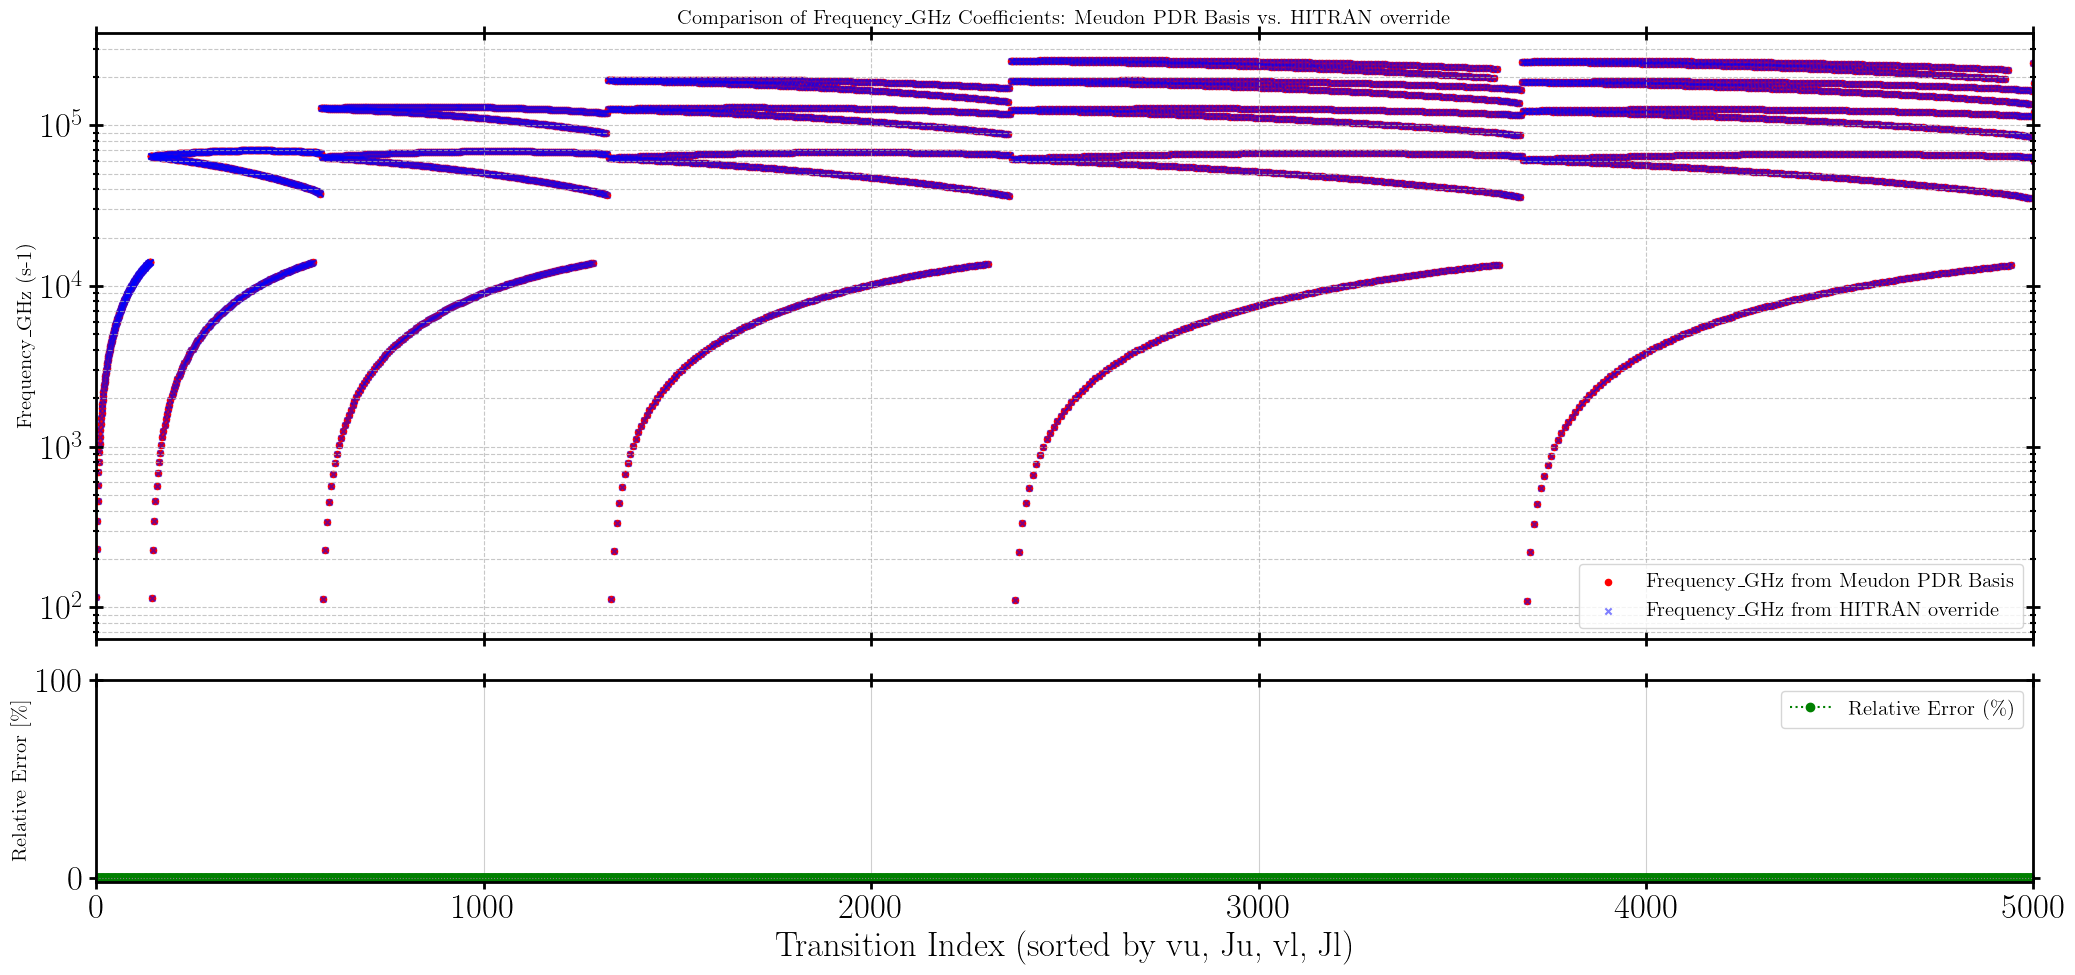

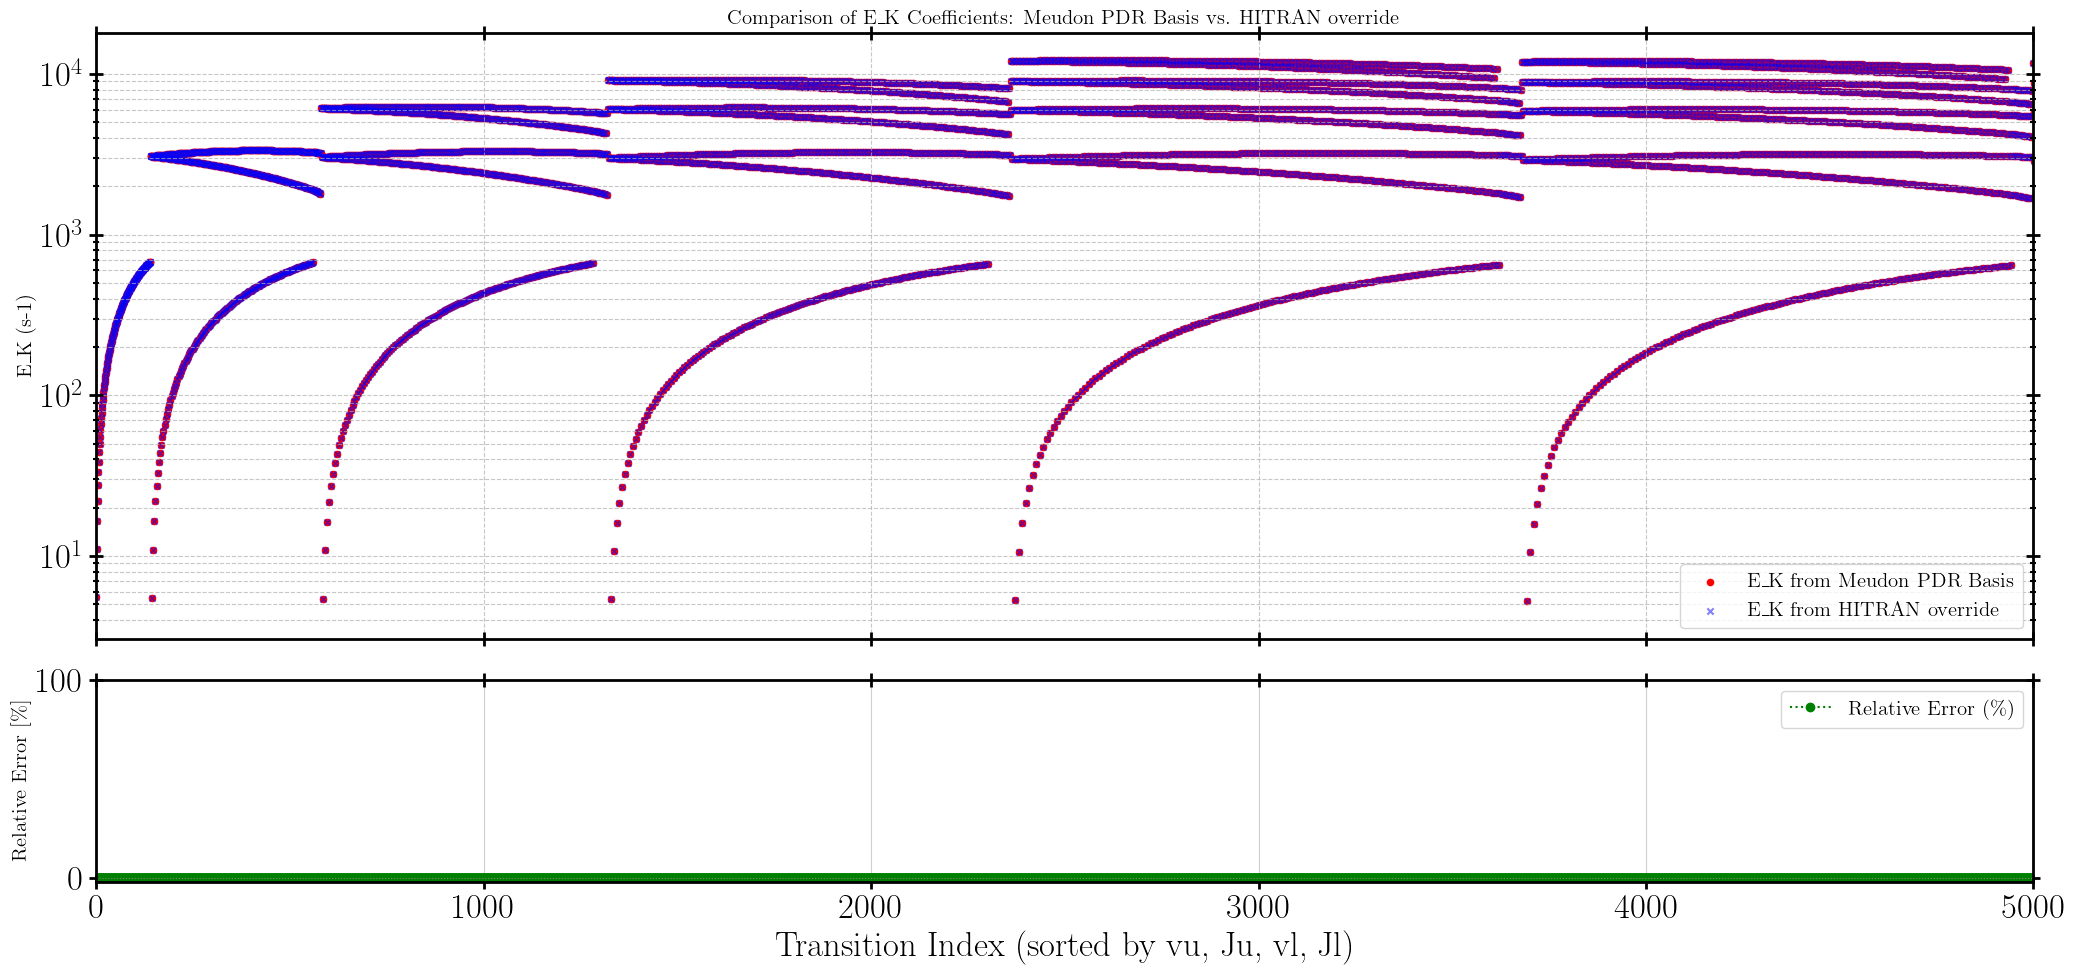

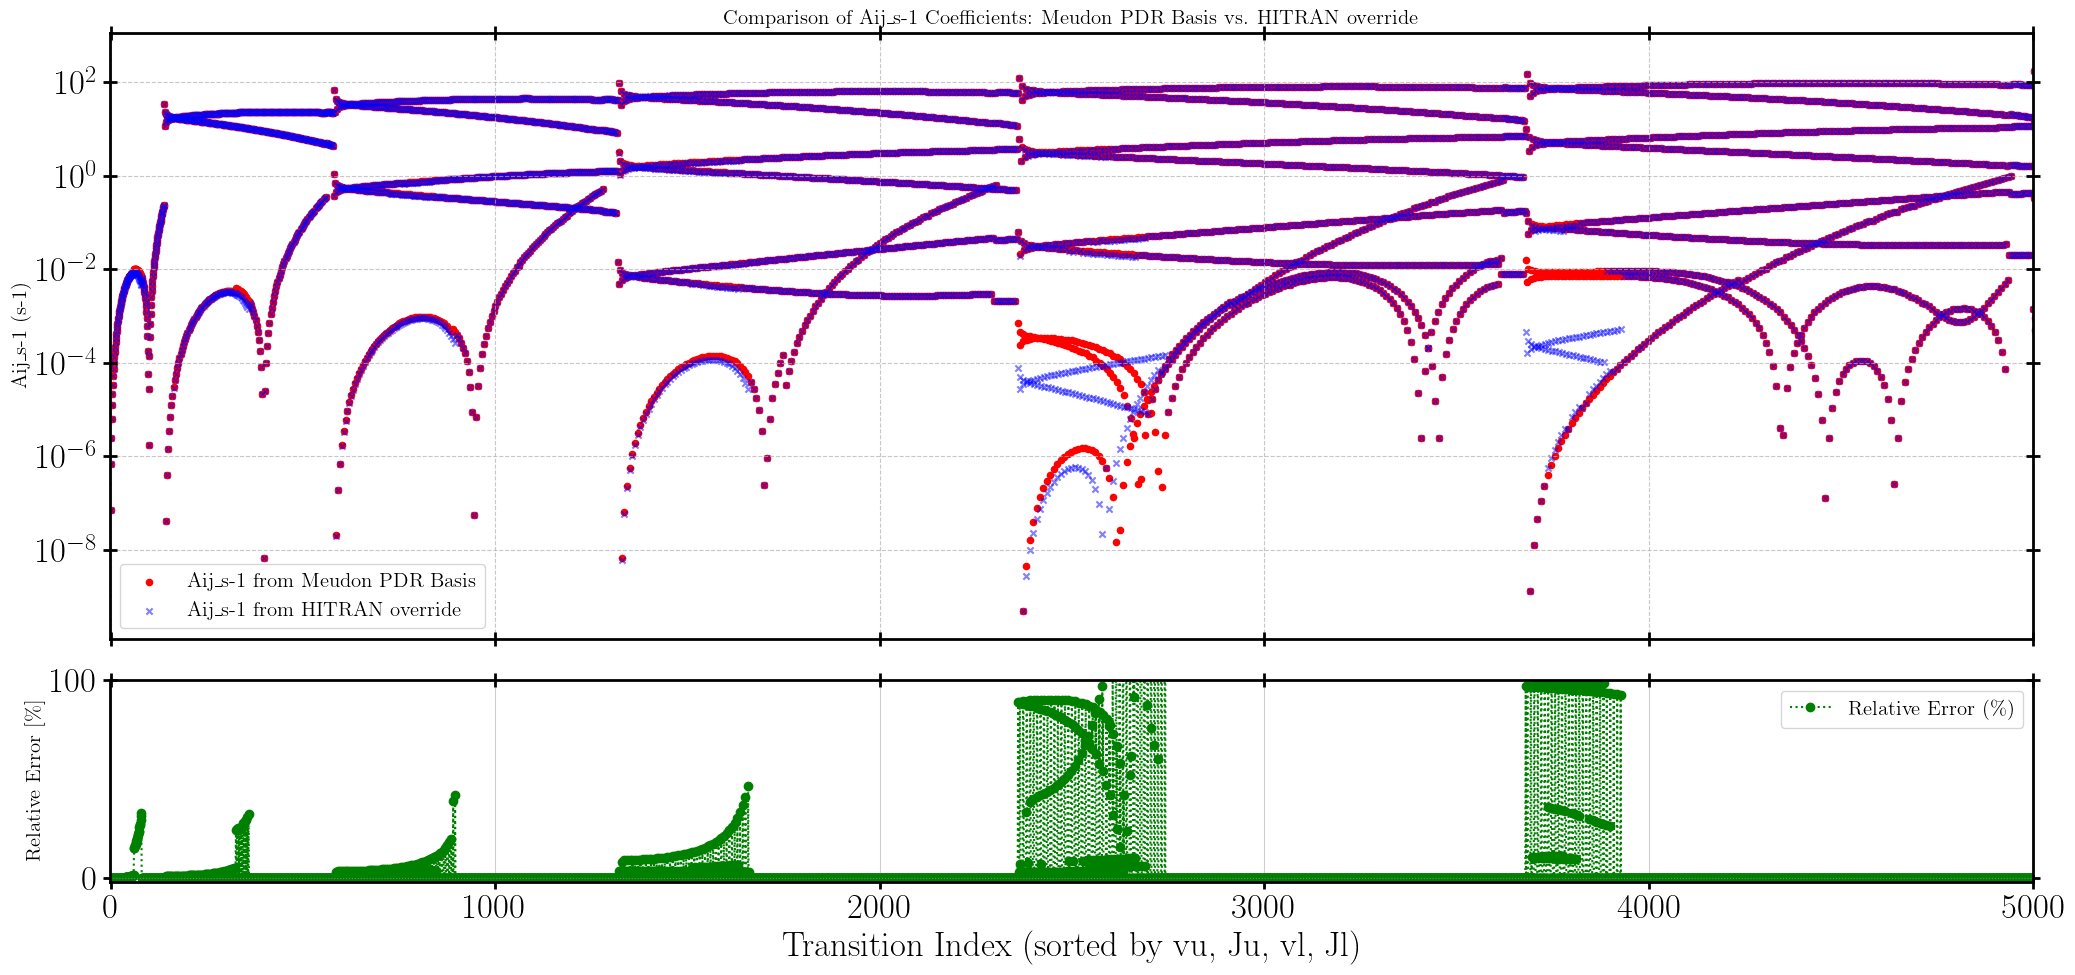

In [72]:
# Graphical check 
viz.Setting_Figure("Excitation")

viz.plot_df_comparison_and_error(df_co_sorted, df_Hitran_final_sorted, "Frequency_GHz",
                             df1_label ="Meudon PDR Basis",df2_label="HITRAN override")    
viz.plot_df_comparison_and_error(df_co_sorted, df_Hitran_final_sorted, "E_K",
                             df1_label ="Meudon PDR Basis",df2_label="HITRAN override")     
viz.plot_df_comparison_and_error(df_co_sorted, df_Hitran_final_sorted, "Aij_s-1",
                             df1_label ="Meudon PDR Basis",df2_label="HITRAN override")    



### Observation of HITRAN Overide 
We see that there is a minimal relative difference between the old and new data for the Energy and wavelength (linked) but a huge change mainly on the Einstein coefficient Aij. 

We see a jump at low v, because HITRAN data don't go further than v=0 J=80, so there is a jump back to the old data at higher rotational data. Same phenomenon for v=1 and 2.

We see a huge difference in behaviour for v=4-0, 4-4, 5-1 and 5-5 with relative difference more than 100%. This is due to unacurate data calculated in Chandra 1996 for those levels and corrected in HITRAN database. 
Note : after running models on the Meudon PDR Code on an Orion Bar like PDR, we see little difference (under 1%) on those levels in this implementation because this process is orders of magnitude lower than others so even a big change in this secondary process doesn't affect much the final result. 

In [73]:
# Check if we have all data 
pio.renderers.default = "notebook"

df_co_to_check = mod.sort_and_create_effective_values(df_co_sorted)
Col = "Aij_s-1"
mod.plot_interactive_plotly(df_co_to_check,c_col=Col,log_color_scale=True,    hover_cols = ['nu','nl','vu', 'Ju', 'vl', 'Jl'])

### Observation on matrix filling 
Note : this is an interactive plot so don't hesitate to slide your mouse on the plot to have more informations. 

We observe the rule of delta J = +-1 specificic for CO, so only few diagonals corresponding from left to right to delta v = 4,3,2,1,0. We observe that the delta v = 0 and delta v =4 are less probable than the three other diagonal which have higher rate

In [74]:
# Writing of the combined file with updated data : 

output_path = '/YourPersonalPath/'
output_filename = "line_co_updated.dat" 


#Prepared for the Meudon PDR Format
num_transitions = len(df_Hitran_final)
header = [
    f"#{num_transitions:d}         # Number of transitions",
    "#K          # Unit energy transitions",
    "#   n     nu     nl           E(K)           Aij(s-1)               quant:    vu      Ju      vl      Jl  info:       Description",
    "#" + "-" * 118 
]

with open(output_path+output_filename, 'w') as f:
    # Header 
    for line in header:
        f.write(line + '\n')
    # Data
    for index, row in df_Hitran_final.iterrows():
        description_part = f"{row['Description_text']}"
        if not pd.isna(row['Frequency_GHz']): 
            description_part += f" {row['Frequency_GHz']:.3f} GHz"

        formatted_line = (
            f"{row['n_trans']:4d} "        # n
            f"{row['nu']:6d} "             # nu
            f"{row['nl']:6d} "             # nl
            f"{row['E_K']:18.8f} "         # E(K)
            f"{row['Aij_s-1']:20.7E} "     # Aij(s-1)
            f"quant: "                     # "quant:"
            f"{row['vu']:5d}; "            # vu
            f"{row['Ju']:5d}; "            # Ju
            f"{row['vl']:5d}; "            # vl
            f"{row['Jl']:5d}; "            # Jl
            f"info:   {description_part}"  # info: + Description
        )
        f.write(formatted_line + '\n')

print(f"\nFichier '{output_filename}' created.")


FileNotFoundError: [Errno 2] No such file or directory: '/YourPersonalPath/line_co_updated.dat'

## 2. Collision update 

Now we will be using the Stancil file to update the collisions with latest data originating from EMA data base and BaseCol database (updated 2025). 

The process here will be a little longer as we have three collisioners (H, ortho H2 and para H2) and one additional dimension (the temperature) with the need to fit to the Meudon PDR temperature grid. 

For each, the data provided range from 2 to 3000 K but the Meudon PDR code needs data from 2 to 20 000K, so we chose to extrapolate every collision coefficient with a constant value identical to the one at 3 000K. For the other points between two temperatures, we chose to do a linear interpolation and we will verify that it fits well the general behaviour of the curves. 


### For H 

In [75]:
df_Stancil_H#.columns

ID   nu  vu  Ju   nl  vl  Jl  gu  gl  E[cm-1]u  ...         500Ke  \
0          1    2   0   1    1   0   0   3   1      3.85  ...  2.500000e-11   
1          2    3   0   2    1   0   0   5   1     11.53  ...  6.310000e-11   
2          3    3   0   2    2   0   1   5   3     11.53  ...  4.450000e-11   
3          4    4   0   3    1   0   0   7   1     23.07  ...  8.510000e-12   
4          5    4   0   3    2   0   1   7   3     23.07  ...  9.850000e-11   
...      ...  ...  ..  ..  ...  ..  ..  ..  ..       ...  ...           ...   
17105  17106  236   5  30  216   4  36  61  73  12153.00  ...  3.820000e-14   
17106  17107  236   5  30  219   4  37  61  75  12153.00  ...  3.110000e-14   
17107  17108  236   5  30  222   4  38  61  77  12153.00  ...  2.520000e-14   
17108  17109  236   5  30  225   4  39  61  79  12153.00  ...  2.020000e-14   
17109  17110  236   5  30  228   4  40  61  81  12153.00  ...  1.560000e-14   

              600Ke         700Ke         800Ke         900Ke        1000Ke  \
0      2.640000e-11  2.750000e-11  2.860000e-11  2.950000e-11  3.030000e-11   
1      6.750000e-11  7.140000e-11  7.490000e-11  7.800000e-11  8.070000e-11   
2      4.770000e-11  5.040000e-11  5.290000e-11  5.530000e-11  5.750000e-11   
3      9.470000e-12  1.040000e-11  1.120000e-11  1.190000e-11  1.260000e-11   
4      1.060000e-10  1.130000e-10  1.190000e-10  1.250000e-10  1.300000e-10   
...             ...           ...           ...           ...           ...   
17105  6.860000e-14  9.890000e-14  1.410000e-13  1.830000e-13  2.250000e-13   
17106  5.740000e-14  8.360000e-14  1.210000e-13  1.590000e-13  1.970000e-13   
17107  4.800000e-14  7.080000e-14  1.060000e-13  1.400000e-13  1.750000e-13   
17108  3.970000e-14  5.920000e-14  8.950000e-14  1.200000e-13  1.500000e-13   
17109  3.160000e-14  4.760000e-14  7.310000e-14  9.850000e-14  1.240000e-13   

             1500Ke        2000Ke        2500Ke        3000Ke  
0      3.320000e-11  3.490000e-11  3.570000e-11  3.600000e-11  
1      9.120000e-11  9.780000e-11  1.020000e-10  1.050000e-10  
2      6.650000e-11  7.300000e-11  7.770000e-11  8.110000e-11  
3      1.540000e-11  1.750000e-11  1.900000e-11  2.010000e-11  
4      1.490000e-10  1.620000e-10  1.700000e-10  1.760000e-10  
...             ...           ...           ...           ...  
17105  4.790000e-13  7.470000e-13  1.010000e-12  1.250000e-12  
17106  4.260000e-13  6.670000e-13  9.020000e-13  1.120000e-12  
17107  3.970000e-13  6.410000e-13  8.850000e-13  1.110000e-12  
17108  3.460000e-13  5.550000e-13  7.560000e-13  9.350000e-13  
17109  2.920000e-13  4.800000e-13  6.680000e-13  8.460000e-13  

[17110 rows x 40 columns]

In [5]:
#Prolongation in Temperature > 3 000 K
T_prolongation = [5000,7000,10000,15000,20000]
Col_T_extrapolated = [f"{T}Ke" for T in T_prolongation]

for i in range (len(df_Stancil_H)): 
    line= df_Stancil_H.iloc[i]
    Extra =calculate.curve_prolongation(Tvalues_H, line[Col_T_H], T_prolongation,method="flat",x_fit_start=3000)
    for j in range (len(T_prolongation)) : 
        df_Stancil_H.at[i,str(T_prolongation[j])+"Ke"]=Extra[j]


# Interpolation in Temperature for T= 3 and 7 K 
T_New_H = [3,7]
Col_T_New_H = [f"{T}Ke" for T in T_New_H]

for i in range (len(df_Stancil_H)): 
    line= df_Stancil_H.iloc[i]
    
    xp = [2,5] #For 3K
    fp = [line["2Ke"], line["5Ke"]]
    df_Stancil_H.at[i,"3Ke"] = np.interp(3, xp, fp)
    
    xp = [5,10] #For 7K
    fp = [line["5Ke"], line["10Ke"]]
    df_Stancil_H.at[i,"7Ke"] = np.interp(7, xp, fp)


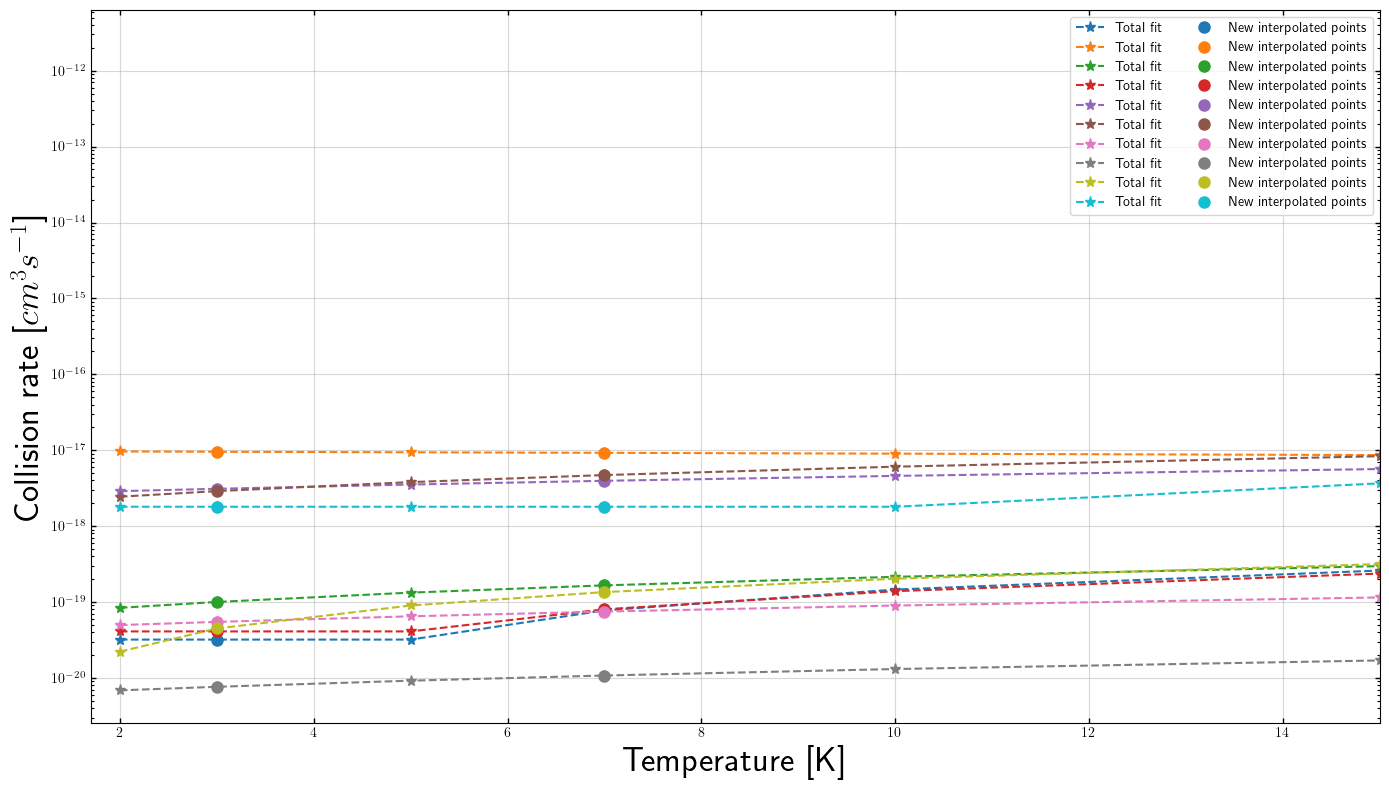

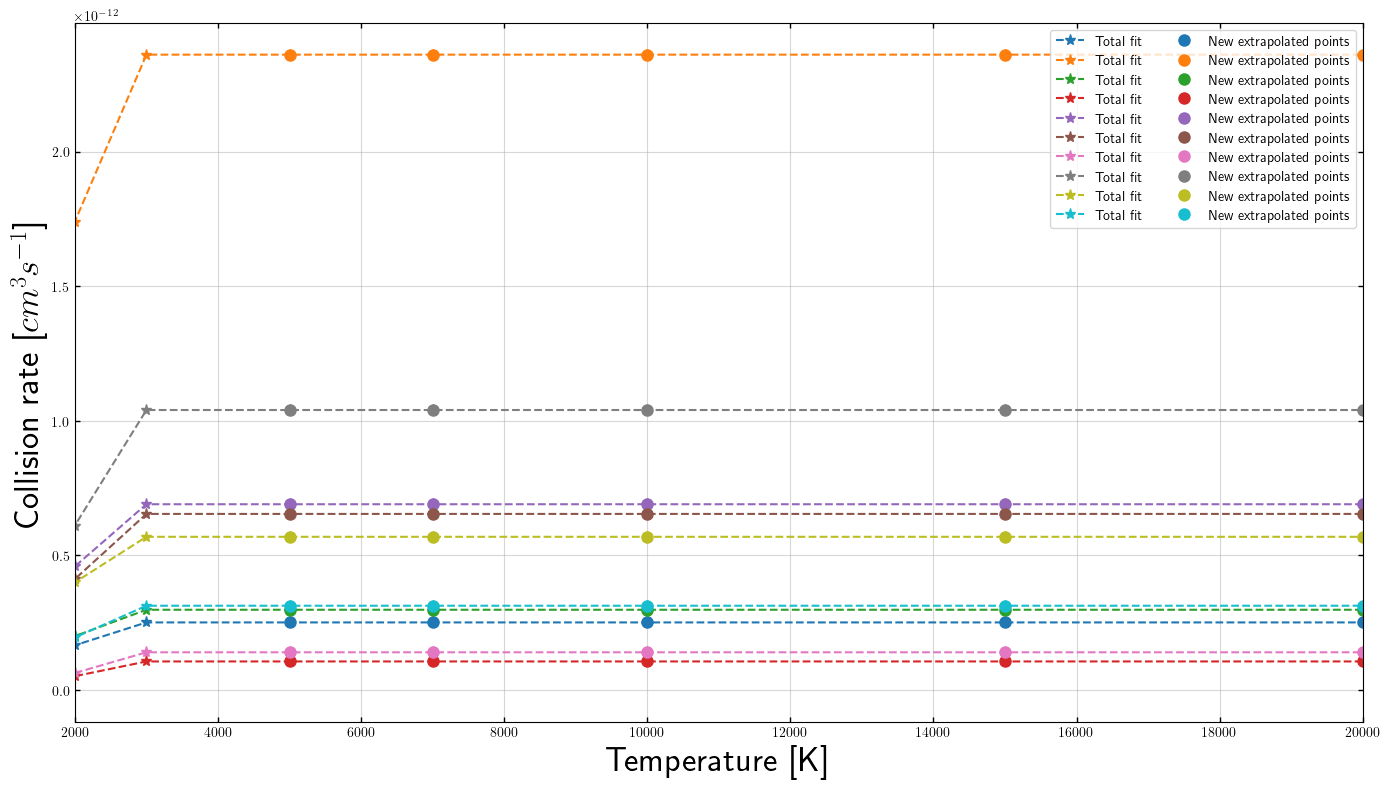

In [6]:
#Check interpolation and prolongation for some random transitions 
sample = df_Stancil_H.sample(n=10)


############ For the interpolation
plt.figure(figsize=(14,8))
for index,row in sample.iterrows() : 
    plt.plot(TGrid_MeudonPDR,row[Col_T_Meudon_int],"*--",label="Total fit",markersize=8)
for index,row in sample.iterrows() : 
    #For lisibilty in the legend 
    plt.plot(T_New_H,row[Col_T_New_H],"o",label="New interpolated points",markersize=8)

plt.grid("--",alpha=0.5)
plt.xlabel("Temperature [K]",fontsize=25)
plt.ylabel(r"Collision rate [$cm^3 s^{-1}$]",fontsize=25)

plt.semilogy()
plt.xlim([1.7,15])
plt.legend(fontsize=10,ncols=2)
plt.tight_layout()  


########## for the extrapolation
plt.figure(figsize=(14,8))
for index,row in sample.iterrows() : 
    plt.plot(TGrid_MeudonPDR,row[Col_T_Meudon_int],"*--",label="Total fit",markersize=8)
for index,row in sample.iterrows() : 
    #For lisibilty in the legend 
    plt.plot(T_prolongation,row[Col_T_extrapolated],"o",label="New extrapolated points",markersize=8)

plt.grid("--",alpha=0.5)
plt.xlabel("Temperature [K]",fontsize=25)
plt.ylabel(r"Collision rate [$cm^3 s^{-1}$]",fontsize=25)

#plt.semilogy()
plt.xlim([2000,20000])
plt.legend(fontsize=10,ncols=2)
plt.tight_layout()  

In [8]:
def merge_unique_rows(df_main: pd.DataFrame, df_new: pd.DataFrame) -> pd.DataFrame:
    keys = ['vu', 'Ju', 'vl', 'Jl']
    merged = pd.merge(df_main, df_new, on=keys, how='outer', indicator=True, suffixes=('_old', '_new'))
    new_only = merged[merged['_merge'] == 'right_only'].rename(
        columns={c: c.replace('_new', '') for c in merged.columns if '_new' in c}
    )[df_new.columns]
    return pd.concat([df_main, new_only], ignore_index=True)
#Merge by adding transitions from the old version to the new grid from Stancil (BaseCol and EMAA)
sorted_transitions = ['vu', 'Ju', 'vl', 'Jl']


df_updated_H  = merge_unique_rows(df_Stancil_H,df_Meudon_H)
#Sort for convenience 
df_updated_H  = df_updated_H.sort_values(by=sorted_transitions, ascending=True)
df_updated_H  = df_updated_H.reset_index(drop=True)
df_updated_H

ID     nu  vu  Ju     nl  vl  Jl    gu    gl  E[cm-1]u  ...  \
0          1.0    2.0   0   1    1.0   0   0   3.0   1.0      3.85  ...   
1          2.0    3.0   0   2    1.0   0   0   5.0   1.0     11.53  ...   
2          3.0    3.0   0   2    2.0   0   1   5.0   3.0     11.53  ...   
3          4.0    4.0   0   3    1.0   0   0   7.0   1.0     23.07  ...   
4          5.0    4.0   0   3    2.0   0   1   7.0   3.0     23.07  ...   
...        ...    ...  ..  ..    ...  ..  ..   ...   ...       ...  ...   
17423  17106.0  236.0   5  30  216.0   4  36  61.0  73.0  12153.00  ...   
17424  17107.0  236.0   5  30  219.0   4  37  61.0  75.0  12153.00  ...   
17425  17108.0  236.0   5  30  222.0   4  38  61.0  77.0  12153.00  ...   
17426  17109.0  236.0   5  30  225.0   4  39  61.0  79.0  12153.00  ...   
17427  17110.0  236.0   5  30  228.0   4  40  61.0  81.0  12153.00  ...   

             2000Ke        2500Ke        3000Ke        5000Ke        7000Ke  \
0      3.490000e-11  3.570000e-11  3.600000e-11  3.600000e-11  3.600000e-11   
1      9.780000e-11  1.020000e-10  1.050000e-10  1.050000e-10  1.050000e-10   
2      7.300000e-11  7.770000e-11  8.110000e-11  8.110000e-11  8.110000e-11   
3      1.750000e-11  1.900000e-11  2.010000e-11  2.010000e-11  2.010000e-11   
4      1.620000e-10  1.700000e-10  1.760000e-10  1.760000e-10  1.760000e-10   
...             ...           ...           ...           ...           ...   
17423  7.470000e-13  1.010000e-12  1.250000e-12  1.250000e-12  1.250000e-12   
17424  6.670000e-13  9.020000e-13  1.120000e-12  1.120000e-12  1.120000e-12   
17425  6.410000e-13  8.850000e-13  1.110000e-12  1.110000e-12  1.110000e-12   
17426  5.550000e-13  7.560000e-13  9.350000e-13  9.350000e-13  9.350000e-13   
17427  4.800000e-13  6.680000e-13  8.460000e-13  8.460000e-13  8.460000e-13   

            10000Ke       15000Ke       20000Ke           3Ke           7Ke  
0      3.600000e-11  3.600000e-11  3.600000e-11  1.993333e-11  1.980000e-11  
1      1.050000e-10  1.050000e-10  1.050000e-10  1.806667e-11  1.948000e-11  
2      8.110000e-11  8.110000e-11  8.110000e-11  2.666667e-11  2.648000e-11  
3      2.010000e-11  2.010000e-11  2.010000e-11  1.543333e-12  1.562000e-12  
4      1.760000e-10  1.760000e-10  1.760000e-10  3.166667e-11  3.332000e-11  
...             ...           ...           ...           ...           ...  
17423  1.250000e-12  1.250000e-12  1.250000e-12  8.460000e-18  1.254000e-17  
17424  1.120000e-12  1.120000e-12  1.120000e-12  1.666667e-17  2.332000e-17  
17425  1.110000e-12  1.110000e-12  1.110000e-12  1.676667e-17  2.266000e-17  
17426  9.350000e-13  9.350000e-13  9.350000e-13  1.733333e-17  2.224000e-17  
17427  8.460000e-13  8.460000e-13  8.460000e-13  1.676667e-17  2.102000e-17  

[17428 rows x 47 columns]

In [104]:
df_Meudon_H.columns 


Index(['ID', 'nu', 'nl', '2Ke', '3Ke', '5Ke', '7Ke', '10Ke', '15Ke', '20Ke',
       '30Ke', '50Ke', '70Ke', '100Ke', '150Ke', '200Ke', '300Ke', '500Ke',
       '700Ke', '1000Ke', '1500Ke', '2000Ke', '3000Ke', '5000Ke', '7000Ke',
       '10000Ke', '15000Ke', '20000Ke', 'vu', 'Ju', 'vl', 'Jl'],
      dtype='object')

In [15]:
TGrid_MeudonPDR = [2.,3.,5.,7.,10.,15.,20.,30.,50.,70.,100.,
            150.,200.,300.,500.,700.,1000.,
            1500.,2000.,3000.,5000.,7000.,10000.,15000.,20000.]
Col_T_Meudon = [f"{T}Ke" for T in TGrid_MeudonPDR]
Col_T_Meudon_int = [f"{int(T)}Ke" for T in TGrid_MeudonPDR]

def abs_rel_error(df1, df2, key_cols, value_cols):
    merged = pd.merge(df1, df2, on=key_cols, how='inner', suffixes=('_1', '_2'))
    #print(merged.columns)
    out = merged[key_cols].copy()
    for col in value_cols:
        a, b = merged[f'{col}_1'], merged[f'{col}_2']
        #print(a,b)
        err = np.where(a != 0, np.abs(a-b)/np.abs(a), 0)
        out[f'{col}_err'] = np.nan_to_num(err, nan=0, posinf=0, neginf=0)
        cleaned_df = out[(out != 0).any(axis=1)]
    return cleaned_df

df_H_comparison = abs_rel_error(df_updated_H,df_Meudon_H,sorted_transitions,Col_T_Meudon_int)
cleaned_df = df_H_comparison[(df_H_comparison != 0).any(axis=1)]

cleaned_df

vu  Ju  vl  Jl    2Ke_err    3Ke_err    5Ke_err    7Ke_err   10Ke_err  \
0      0   1   0   0   7.330729   7.413043   7.317757   8.350000  10.091954   
1      0   2   0   0   4.976301   4.573801   3.969388   3.891581   3.823834   
2      0   2   0   1  12.115058  11.759750  11.092199  11.896148  13.309623   
3      0   3   0   0  32.586000  28.409719  23.417178  22.367478  21.808219   
4      0   3   0   1   5.711475   5.195789   4.470588   4.389256   4.356037   
...   ..  ..  ..  ..        ...        ...        ...        ...        ...   
1894   1  22   1  17   0.000000   0.000000   0.000000   0.000000   0.000000   
1895   1  22   1  18   0.000000   0.000000   0.000000   0.000000   0.000000   
1896   1  22   1  19   0.000000   0.000000   0.000000   0.000000   0.000000   
1897   1  22   1  20   0.000000   0.000000   0.000000   0.000000   0.000000   
1898   1  22   1  21   0.000000   0.000000   0.000000   0.000000   0.000000   

       15Ke_err  ...  700Ke_err  1000Ke_err  1500Ke_err  2000Ke_err  \
0     12.214000  ...   7.654545    6.623762    5.566265    4.873926   
1      3.471340  ...   0.540616    0.598513    0.655702    0.656442   
2     14.675355  ...   5.468254    4.565217    3.616541    2.986301   
3     19.020290  ...   1.153846    0.825397    0.402597    0.097143   
4      3.981073  ...   0.707965    0.707692    0.691275    0.635802   
...         ...  ...        ...         ...         ...         ...   
1894   0.000000  ...   0.000000    0.000000    0.000000    0.000000   
1895   0.000000  ...   0.000000    0.000000    0.000000    0.000000   
1896   0.000000  ...   0.000000    0.000000    0.000000    0.000000   
1897   0.000000  ...   0.000000    0.000000    0.000000    0.000000   
1898   0.000000  ...   0.000000    0.000000    0.000000    0.000000   

      3000Ke_err  5000Ke_err  7000Ke_err  10000Ke_err  15000Ke_err  \
0       3.916667    3.916667    3.916667     3.916667     3.916667   
1       0.533333    0.533333    0.533333     0.533333     0.533333   
2       2.144266    2.144266    2.144266     2.144266     2.144266   
3       0.263682    0.263682    0.263682     0.263682     0.263682   
4       0.471591    0.471591    0.471591     0.471591     0.471591   
...          ...         ...         ...          ...          ...   
1894    0.000000    0.000000    0.000000     0.000000     0.000000   
1895    0.000000    0.000000    0.000000     0.000000     0.000000   
1896    0.000000    0.000000    0.000000     0.000000     0.000000   
1897    0.000000    0.000000    0.000000     0.000000     0.000000   
1898    0.000000    0.000000    0.000000     0.000000     0.000000   

      20000Ke_err  
0        3.916667  
1        0.533333  
2        2.144266  
3        0.263682  
4        0.471591  
...           ...  
1894     0.000000  
1895     0.000000  
1896     0.000000  
1897     0.000000  
1898     0.000000  

[1899 rows x 29 columns]

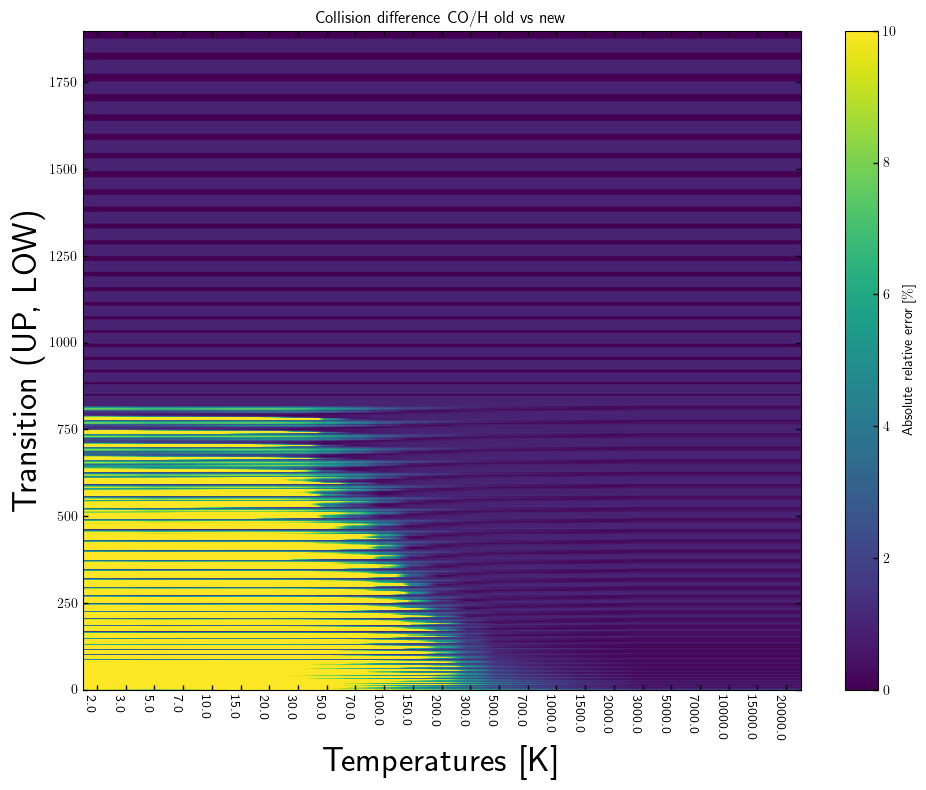

In [24]:
#2D histogram of relative difference in % between old and new transitions 
columns_compare = [f"{c}_err" for c in Col_T_Meudon_int]
df_data = df_H_comparison[columns_compare]
liste_de_floats = [float(col.replace('Ke_err', '')) for col in columns_compare]
#y_labels = [f"UP={row['UP']}, LOW={row['LOW']}" for _, row in df_difference_filtre[['UP', 'LOW']].iterrows()]


data = df_data.to_numpy()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data, cmap="viridis", aspect='auto', origin='lower', vmin=0, vmax=10)
fig.colorbar(im, ax=ax, label=r'Absolute relative error [$\%$]')

#ax.set_yticks(np.arange(len(df_comparaison_H_new.index)))
ax.set_xticks(np.arange(len(columns_compare)))
#ax.set_yticklabels(y_labels)
ax.set_xticklabels(liste_de_floats)

plt.setp(ax.get_xticklabels(), rotation=-90, ha="right")
ax.set_ylabel('Transition (UP, LOW)',size=25)
ax.set_xlabel('Temperatures [K]',size=25)
ax.set_title('Collision difference CO/H old vs new')

plt.tight_layout()
plt.show()


In [98]:
def compare_and_filter(df1, df2, key_cols, compare_cols, threshold):
    merged = pd.merge(df1, df2, on=key_cols, how='inner', suffixes=('_1', '_2'))
    for col in compare_cols:
        err = np.where(merged[f'{col}_1'] != 0,
                       np.abs(merged[f'{col}_1'] - merged[f'{col}_2']) / merged[f'{col}_1'],
                       0)
        merged[f'{col}_err'] = np.nan_to_num(err, nan=0, posinf=0, neginf=0)
        merged.drop([f'{col}_1', f'{col}_2'], axis=1, inplace=True)
    error_cols = [f'{c}_err' for c in compare_cols]
    filtered = merged[merged[error_cols].gt(threshold).any(axis=1)].copy()
    return filtered

In [ ]:
df_difference_filtre = compare_and_filter(df_comparaison_H_new)


# Utilisation de df_comparaison_H_new pour la visualisation
columns_compare = [f"{c}_erreur" for c in col_a_comparer]
df_data = df_comparaison_H_new[columns_compare]
y_labels = [f"UP={row['UP']}, LOW={row['LOW']}" for _, row in df_difference_filtre[['UP', 'LOW']].iterrows()]

# Récupération des valeurs de température pour l'axe X
liste_de_floats = [float(col.replace('_erreur', '')) for col in columns_compare]

data = df_data.to_numpy()



fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data, cmap="viridis", aspect='auto', origin='lower', vmin=0, vmax=10)
fig.colorbar(im, ax=ax, label=r'Absolute relative error [$\%$]')

#ax.set_yticks(np.arange(len(df_comparaison_H_new.index)))
ax.set_xticks(np.arange(len(columns_compare)))
#ax.set_yticklabels(y_labels)
ax.set_xticklabels(liste_de_floats)
#
plt.setp(ax.get_xticklabels(), rotation=-90, ha="right")

ax.set_ylabel('Transition (UP, LOW)',size=25)
ax.set_xlabel('Temperatures [K]',size=25)

ax.set_title('Collision difference CO/H old vs new')

plt.tight_layout()
plt.show()

In [97]:

df_check_H = relative_error_df(df_Meudon_H, df_updated_H,keys=["vu","Ju","vl","Jl"],vals=Col_T_Meudon)

#columns_compare = df_check_H.columns[23:]
#df_data = df_check_H[columns_compare]

KeyError: '2.0Ke_ref'

In [56]:
def merge_unique_rows(df_main: pd.DataFrame, df_new: pd.DataFrame) -> pd.DataFrame:
    keys = ['vu', 'Ju', 'vl', 'Jl']
    merged = pd.merge(df_main, df_new, on=keys, how='outer', indicator=True, suffixes=('_old', '_new'))
    new_only = merged[merged['_merge'] == 'right_only'].rename(
        columns={c: c.replace('_new', '') for c in merged.columns if '_new' in c}
    )[df_new.columns]
    return pd.concat([df_main, new_only], ignore_index=True)


    

def relative_error_df(df1, df2, keys, vals):
    merged = pd.merge(df1, df2, on=keys, how='inner', suffixes=('_ref', '_comp'))
    result = merged[keys].copy()
    for v in vals:
        a, b = merged[f'{v}_ref'], merged[f'{v}_comp']
        err = np.where(a != 0, np.abs(a-b)/a, 0)
        result[f'{v}_err'] = np.nan_to_num(err, nan=0, posinf=0, neginf=0)
    return result






In [23]:
# Check of prolongation 





#Check of interpolation 





# Comparison between old and new data 
columns_compare = df_comparaison_ph2_2.columns[23:]
df_data = df_comparaison_ph2_2[columns_compare]

cleaned_index = columns_compare.str.replace('Ke_erreur', '')
liste_de_floats = cleaned_index.astype(float).tolist()

y_labels = [f"vu={row['vu']}, Ju={row['Ju']}, vl={row['vl']}, Jl={row['Jl']}" 
            for _, row in df_comparaison_ph2_2[['vu', 'Ju', 'vl', 'Jl']].iterrows()]


data = df_data.to_numpy()

fig, ax = plt.subplots(figsize=(10, 8))


im = ax.imshow(data, cmap="viridis", aspect='auto', origin='lower', vmin=0,vmax=10)

fig.colorbar(im, ax=ax, label='relative error [%]')


#ax.contour(data, levels=[1], colors='red', linewidths=2.0)

ax.set_yticks(np.arange(len(df_comparaison_ph2_2.index)))
ax.set_xticks(np.arange(len(columns_compare)))
ax.set_yticklabels(df_data.index) 
#ax.set_yticklabels(y_labels)
ax.set_xticklabels(liste_de_floats,rotation=60)

ax.set_ylabel('Lines (Index)')
ax.set_xlabel('Temperatures [K]')

plt.tight_layout()
plt.show()

ValueError: could not convert string to float: '3000Ke_error_rel'

### Observations : 
The extrapolations in temperatures are acceptable because CO will never receive that much heat in PDR regions 
The interpolations between points is valid and reflects well the general behaviour of the collision rates 

Concerning the comparison, we observe a difference at high temperature resulting from our choice in extrapolation, and we also observe that certain transitions have a huge difference (multiple order of magnitude). This is due to an initial value of 1e-30 to 1e-33 put into the code by Jacques Le Bourlot through an old analytical formula to put them "to 0" with the accurate amount of numbers to fit the format.